## Imports and Dataset Loading

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dropout, Dense, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the IMDb dataset
# Limit the number of words to vocab_size and pad sequences to maxlen
(vocab_size, embedding_dim, maxlen) = (10000, 128, 500)
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

## Data Preprocessing

In [4]:
# Pad sequences to ensure uniform input size
# This converts each review to a fixed length of maxlen
train_data_padded = pad_sequences(train_data, maxlen=maxlen)
test_data_padded = pad_sequences(test_data, maxlen=maxlen)

## Define the Model

In [6]:
from tensorflow.keras import regularizers

# Define an enhanced RNN model
model = Sequential()
# Embedding layer: Converts word indices to dense vectors of fixed size
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
# Bidirectional GRU layer: Processes sequences in both directions
model.add(Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
# Normalize the activations to stabilize training
model.add(LayerNormalization())
# Dropout layer: Helps prevent overfitting by randomly setting a fraction of input units to 0
model.add(Dropout(0.2))
# Another Bidirectional GRU layer
model.add(Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
# Normalize activations
model.add(LayerNormalization())
# Dropout layer
model.add(Dropout(0.2))
# Another Bidirectional GRU layer with reduced units
model.add(Bidirectional(GRU(32, kernel_regularizer=regularizers.l2(0.01))))
# Dropout layer
model.add(Dropout(0.2))
# Output layer: Single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
# Using Adam optimizer with a learning rate of 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary to see the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 256)         198144    
 l)                                                              
                                                                 
 layer_normalization (LayerN  (None, 500, 256)         512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 500, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 128)         123648    
 nal)                                                            
                                                        

## Train the Model

In [8]:
# Define callbacks
# Early stopping: Stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
# Learning rate scheduler: Reduce the learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    train_data_padded, train_labels,
    epochs=20,  # Number of epochs to train
    batch_size=64,  # Size of each batch
    validation_split=0.2,  # Fraction of training data to use for validation
    callbacks=[early_stopping, lr_scheduler]  # Callbacks to monitor training
)

Epoch 1/20
313/313 [==============================] - 96s 282ms/step - loss: 2.3230 - accuracy: 0.7620 - val_loss: 0.4712 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 88s 281ms/step - loss: 0.3679 - accuracy: 0.9017 - val_loss: 0.3362 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 88s 282ms/step - loss: 0.2260 - accuracy: 0.9395 - val_loss: 0.3719 - val_accuracy: 0.8714 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 88s 282ms/step - loss: 0.1666 - accuracy: 0.9560 - val_loss: 0.3686 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 88s 281ms/step - loss: 0.1063 - accuracy: 0.9768 - val_loss: 0.4078 - val_accuracy: 0.8816 - lr: 5.0000e-04
Epoch 6/20
313/313 [==============================] - 88s 280ms/step - loss: 0.0873 - accuracy: 0.9821 - val_loss: 0.4679 - val_accuracy: 0.8746 - lr: 5.0000e-04


## Evaluate the model

In [10]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data_padded, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

782/782 [==============================] - 78s 100ms/step - loss: 0.3491 - accuracy: 0.8852
Test Accuracy: 0.8852
Test Loss: 0.3491


## Predict and Display Results

782/782 [==============================] - 76s 95ms/step
              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89     12500
    Positive       0.90      0.87      0.88     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



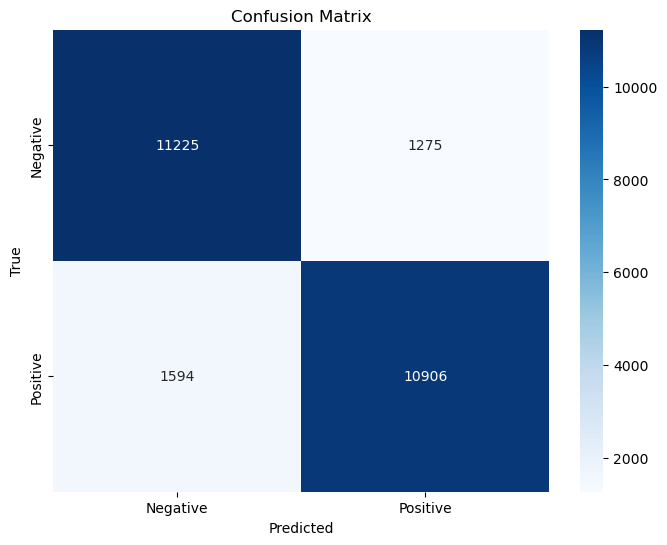

In [12]:
# Predict sentiments on the test data
# Generate predictions and convert probabilities to binary labels
predictions = model.predict(test_data_padded)
predicted_labels = (predictions > 0.5).astype(int)

# Display classification report
# This report includes precision, recall, and F1-score for each class
print(classification_report(test_labels, predicted_labels, target_names=['Negative', 'Positive']))

# Plot confusion matrix
# This matrix shows true vs. predicted class labels
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()